
# Reinforcement Learning
RL involves an agent exploring an environment consisting of states and gathering information about its environment as it makes actions.
In this assignment, we make simplifying assumptions that with every action, the agent transits to a new state. We also make Markov assumptions about the transition function, moving to a new state at the next time step depends only on the current state, action pair. 

## Q Learning
Q-Learning is a Reinforcement Learning algorithm, which aims to learn an optimal policy that maximises the total reward.
In this homework, we build up Q-Learning with a simple environment for you.

You can find a lot of info online on Q-Learning. [Here's](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/deep_q_learning.html) an example of a pretty good resource. The key is implementing the iterative update equations that maintain our Q function.

## Environment
We implemented a very simple environment based on one from OpenAI Gym for you.
In this game, we start at the square marked H for home, and our goal is to get to the square marked G.
Along the way, we have pits P that cause us to immediately lose,
slippery squares marked S that can send us in a random direction,
and dry squares marked D we can walk on normally.

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
H = 0 # Home: starting point
S = 1 # Slippery
D = 2 # Dry
P = 3 # Pit: doom
G = 4 # Goal

maze_small = np.array(
        [
          [H, D, D, S],
          [S, P, D, P],
          [D, S, S, D],
          [P, D, S, G],
        ],
        dtype=np.float32)
maze_big = np.array(
        [
            [H, D, S, S, P, S, D, S],
            [P, D, S, S, D, P, S, P],
            [S, S, S, S, P, D, S, S],
            [S, D, P, S, D, S, S, P],
            [D, S, P, S, D, S, D, S],
            [S, S, S, P, S, P, P, D],
            [S, P, S, P, D, S, S, S],
            [S, D, S, S, D, P, G, S],
        ],
        dtype=np.float32)

We'll start with a small maze, but feel free to try switching to the large maze when you get a good handle of the problem. The current location of our agent will be stored in a 2 dimensional ndarray.
We use numbers for movements so our agent can send a movement direction to the environment.

In [3]:
maze = maze_small
loc = np.array([0, 0]) # y, x

UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
SLIP_PERCENT = 0.4 # Slipping from S

Resetting the environment will mean locating the home square and setting loc to its location.

In [4]:
def env_reset():
    global loc
    # Find location of start
    loc = np.dstack(np.nonzero(maze == H)).squeeze()
    return (0, 0., {'maze':np.copy(maze), 'loc':np.copy(loc)})

In [ ]:
env_reset()

(0, 0.0, {'loc': array([0, 0]), 'maze': array([[0., 2., 2., 1.],
         [1., 3., 2., 3.],
         [2., 1., 1., 2.],
         [3., 2., 1., 4.]], dtype=float32)})

Notice that we return a few other things. We'll see what they are in a second. In the meantime, here's a function to print the environment.
Whenever you want to see what's going on, using this is a good idea.

In [5]:
def env_print():
    ''' Print the environment '''
    global loc, maze
    print('')
    # chars = ['H', '~', '.', 'O', 'G'] 
    chars = ['H', 'S', 'D', 'P', 'G']
    for i, row in enumerate(maze):
        for j, num in enumerate(row):
            if i == loc[0] and j == loc[1]:
                char = 'X'
            else:
                char = chars[int(num)]
            print(char, end=' ')
        print('')

In [ ]:
env_print()


X D D S 
S P D P 
D S S D 
P D S G 


The following is the implementation of the actual logic of the environment. An environment takes an input (action) and computes the resulting state.
It returns 1 if the game is done, the reward for the last step taken, and the observation/state of the environment.

## Rewards
Rewards are a really tricky part of RL, as they can cause large changes to agent behavior.
In our simple environment, the reward is simple: 1 if you reach the goal, -1 if you fall in a pit, and 0 otherwise.
  
## Observations/State
State is another complicated matter. In some games, an agent can only observe some of the environment at any one time.
This makes these games much harder.
In our game, the agent gets back the whole state of the game. We'll initially use only the location part of the state though.

## Actions
Our agent can only give us the actions UP, DOWN, LEFT or RIGHT as defined above.

## Dynamics
What kinds of dynamics does the environment need to take care of? Again, our environment is quite simple.

* If the agent tries to move out of bounds, we ignore that action and 
* If the agent falls into a pit, the game is done and we give negative reward (-1).
* If the agent gets to the goal, the game is done and we give positive reward (+1).
* If the agent is currently on a slippery square, we ignore his action with a 40% chance,
and instead choose from any other legitimate direction (ie not out of bounds).


In [6]:
def env_step(action):
    global loc
    
    
    # UP, DOWN, RIGHT, LEFT
#    moves = [(-1, 0), (1, 0), (0, 1), (0, -1)]
    moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    move = np.array(moves[action])

    # Check if slippery
    if maze[tuple(loc)] == S:
        if random.random() < SLIP_PERCENT:
            move = np.array(random.choice(moves))

    loc2 = loc + move

    reward = 0.
    done = 0
    
    
    # Bounds check
    if loc2[0] >= 0 and loc2[1] >= 0 and loc2[0] < len(maze) and loc2[1] < len(maze[0]):
        loc = loc2 # Update loc

        if maze[tuple(loc)] == G:
            reward = 1.
            done = 1
        elif maze[tuple(loc)] == P:
            reward = -1.
            done = 1
        

    return (done, reward, {'maze':np.copy(maze), 'loc':np.copy(loc)})

In [ ]:
# You can try give your environment directions and print it here to test it out.
env_reset()
env_print()
env_step(DOWN)
env_print()
env_step(RIGHT)
env_print()
env_step(RIGHT)
env_print()
env_step(DOWN)
env_print()
env_reset()


X D D S 
S P D P 
D S S D 
P D S G 

X D D S 
S P D P 
D S S D 
P D S G 

H D D S 
X P D P 
D S S D 
P D S G 

H D D S 
S P D P 
X S S D 
P D S G 

H D D S 
S P D P 
X S S D 
P D S G 


(0, 0.0, {'loc': array([0, 0]), 'maze': array([[0., 2., 2., 1.],
         [1., 3., 2., 3.],
         [2., 1., 1., 2.],
         [3., 2., 1., 4.]], dtype=float32)})

# Q Table

In Q-Learning we build a Q-Table to store Q values for all possible combinations of state and action pairs. The agent's policy, will be to choose to move into the next state which has the highest expected reward.

Since we're only using location as our state, we can have an array of size 4x4, but then we need another dimension for the actions,
making a tensor of 4x4x4. In each slot in our array, we'll store the value of that state-action combination,
where value is the expected reward for the rest of the game. For example, in (0,0,1), we'll store the value of taking the action DOWN, when at location (0,0).

The key step in updating our Q-table is the following:

\begin{equation}
Q(s_t, a_t) \leftarrow (1-\alpha)Q(s_t, a_t) + \alpha [R(s_{t+1}) + \gamma \max_{a} Q(s_{t+1}, a)]
\end{equation}



Our algorithm is: reset the environment and initialize Q-table values randomly. 

```
Loop for each episode:
  Loop for each time step:
    Choose Action a at State s using policy derived from Q-table (eps-greedy)
    Take action a, observe R, s' (next state)
    Update Q(s,a) 
    Update current state
```

We use an epsilon-greedy approach ie. we have epsilon chance of making a random move rather than using our Q-table.

The idea behind epsilon-greedy is to explore more of the environment rather than exploit all we've seen so far. If we do end up using our knowledge held in the Q table (with 1-epsilon chance), we'll want to
look at our current state in the array and take the action that gives us the higest value.

After choosing a move, we tell the environment what the move was.
The environment will hand us back the next state, our reward, and whether we're done.
Now we need to update our knowledge of the environment.
We'll update the value of the last state-action by mixing in the reward we just got, plus little bit of the value of the new state we arrived at $s'$.
But how do we know the value of $s'$? Well, let's take the maximum value of $s'$ over all its possible actions.
$\alpha$ determines how much we 'mix in' the value of the new state-action. $\gamma$ is used to attenuate the reward signal coming in from the 
next state $s'$. The hypothesis is that the further away the reward is, the less valuable it is, so it gets reduced by $\gamma$ for every step
we get away from it. 


In [ ]:
# Q array
# state (4x4) * actions (4)
q = np.zeros((4,4,4), dtype=np.float32)

rewards = []
epochs = 10000
epsilon = 0.6
gamma = 0.9
alpha = 0.1

(done, reward, state) = env_reset()
state = tuple(state['loc'])

for epoch in range(epochs):
    #print('Epoch', epoch) # For debugging
    iter = 0
    ep_reward = 0
    while not done:
        # Epsilon-greedy
        if random.random() < epsilon:
            action = random.choice([UP, DOWN, LEFT, RIGHT])
        else:
            action = np.argmax(q[state])

        (done2, reward, state2) = env_step(action)
        ep_reward += reward
        state2 = tuple(state2['loc'])

        max_action2 = np.argmax(q[state2])
        # Mix the current value of q at the old state-action with the reward we just got, added to
        # the value of q at state2 and max_action2 * gamma. Alpha determines the mixture percentages.
        q[state][action] = (1-alpha) * q[state][action] + alpha * (reward + gamma * q[state2][max_action2])
        state = state2
        done = done2
        iter += 1

    (done2, reward, state) = env_reset()
    done = done2
    state = tuple(state['loc'])
    rewards.append(ep_reward)

    epsilon -= 0.0001 # Reduce epsilon a little: we know a little bit more now
   

Plotting the reward signal in our case will not produce great results.
We plot the reward signal summed over 100 episodes to view the results.

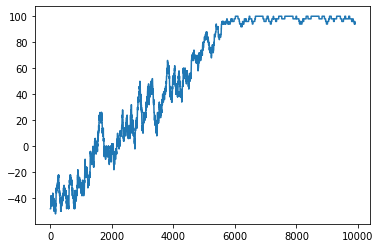

In [ ]:
rewards2 = []
for i in range(0, len(rewards)):
    rewards2.append(sum(rewards[i:i+100]))
    
plt.plot(rewards2[:-100])
plt.show()
    
    

Print out Q for all states, for the movement down action:

In [ ]:

print(q[:, :, 0])


[[ 0.5438241   0.60394055  0.28928053 -0.01999697]
 [-0.39426523  0.         -0.99999976  0.        ]
 [ 0.55400515  0.22195193  0.73930275  0.8999995 ]
 [ 0.          0.8160961   0.908287    0.        ]]


# Neural Network

Notice that we haven't used deep learning yet! There are 2 issues with the above approach:
1. It doesn't scale up. If we enlarge our maze or our action space, it'll run out of memory.
2. It only works for states we've seen. What about states we haven't seen? We want to be able to generalize.

Let's bring a neural network into this. Our neural network will replace the job of the Q array we used above. That is, the function that is Q (the value of every state-action) will be represented by our NN. We'll simplify things a little though: instead of taking the current state-action as input, we'll just take the current state as input, and produce one output value per action.

Create a network with 3 linear layers, of hidden dimension sizes 8 and 16.
Add 2 internal ReLU layers. The input and output sizes need to fit our needs.


In [13]:
# Neural Network

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#maze = maze_big
maze = maze_small

#TODO define your model here
#A simple start point is a 3-layer MLP (usig Relu as activation function) 
#with 8, 16 as intermediate channel numbers. Feel free to design your own model
N_ACTIONS = 4
class Net(nn.Module):
    def __init__(self,):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(2,8)
        self.linear2 = nn.Linear(8,16)
        self.out = nn.Linear(16,N_ACTIONS)
    def forward(self,x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.out(x)
        return x


Now let's implement the neural network version. We'll need:

  * An optimizer declared before the loop
  * To use zero_grad(), calculate a loss, and optimizer.step()
  * Our loss will be slightly different. We don't need alpha anymore, since the optimizer naturally takes small steps. Our loss will be the squared l2 loss between:
     * the reward + (gamma times the optimal Q of the next state-action)
     * and the current Q for the current state-action that was taken.
  * Don't forget to think about which parts of Q need to keep gradients and which don't. Which parts are we trying to modify?
  

In [17]:
epochs = 15000
epsilon = 0.3
gamma = 0.9
lr = 0.001
rewards = []

(done, reward, state) = env_reset()
state = torch.from_numpy(state['loc']).float()
#TODO initialize your model here
q = Net()
target_q = Net()
optimizer = optim.Adam(lr=lr, params=q.parameters())
loss_func = nn.MSELoss()
replace_iter = 1300

for epoch in range(epochs):
    # print('Epoch', epoch) # For debugging
    iter = 0
    ep_reward = 0.
    while not done:
        if epoch % replace_iter == 0:
            target_q.load_state_dict(q.state_dict())
        # Take a step
        if iter > 200: # Let's make sure we don't get stuck in a loop
            print(epoch,"stuck")
            break
        if random.random() < epsilon:
            action = random.choice([UP, DOWN, LEFT, RIGHT])
        else:
            #TODO choose action according to the client
            #You might not want to calculate gradient on this action,
            #Use with torch.no_grad(): to achieve that.
            with torch.no_grad():
              action = torch.max(q(state),0)[1].data.numpy() 

        (done2, reward, state2) = env_step(action)
        ep_reward += reward
        state2 = torch.from_numpy(state2['loc']).float()

        # Now learn
        # TODO implement learning procedure here
        # hint: predict q_values of each action, calculate the l2 loss mentioned above
        #       then do gradient descent
        q_values = q(state)[action]
        q_next = target_q(state2).detach()
        q_target = reward + gamma * torch.max(q_next,0)[0]
        loss = loss_func(q_values,q_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = state2
        done = done2
        iter += 1

    (done2, reward, state) = env_reset()
    done = done2
    state = torch.from_numpy(state['loc']).float()
    rewards.append(ep_reward)
    #print(ep_reward)

    epsilon -= 0.00004
    # epsilon = max(0.05, epsilon)

2168 stuck
2657 stuck
2674 stuck
2725 stuck
2829 stuck
2831 stuck
2890 stuck
3031 stuck
3039 stuck
3052 stuck
3123 stuck
3165 stuck
3200 stuck
3202 stuck
3243 stuck
3281 stuck
3297 stuck
3300 stuck
3319 stuck
3535 stuck
3843 stuck
3845 stuck
3887 stuck
3893 stuck


Once again, plot the rewards over time windows of 100 episodes so we get a better picture of performance

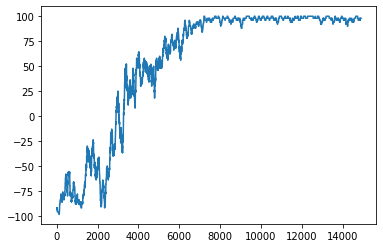

In [18]:
rewards2 = []
for i in range(0, len(rewards)):
    rewards2.append(sum(rewards[i:i+100]))
plt.plot(rewards2[:-100])
plt.show()

There's an issue that occurs when we try to use neural networks: Q-Learning is unstable because when the agent explores an environment,
each sample is dependent on the previous one ie. they're not IID.

One fix for this problem is called Experience Replay, where we insert a state, action, reward, result state into our replay memory, and for the learning part, we sample
some of it and learn from it. This is like getting 'flashbacks' of our recent behavior. This has another advantage: we can now learn with mini-batches, which is also more stable.

Here's the memory class.

In [19]:
# Experience Replay Memory -----
class Memory(object):
    def __init__(self, size=1000):
        self.memory = []
        self.max_size = size
        self.index = 0

    def store(self, x):
        if len(self.memory) < self.max_size:
            self.memory.append(x)
        else:
            self.memory[self.index] = x
            self.index = (self.index + 1) % self.max_size

    def sample(self, num):
        if len(self.memory) < num:
            return self.memory
        else:
            return random.sample(self.memory, num)


Try creating a memory object, inserting some data, and then sampling from it. Notice how we insert sequentially, but get back a random mix of data.

In [20]:
memory = Memory()
memory.store(1)
memory.store(2)
memory.store(3)
memory.sample(2)

[1, 2]

Now modify our neural network to use experience replay memory. We'll place the training in a separte function since we don't want
python to get confused with our variable names, and walking through the environment is now completely separate from learning
about it.

The biggest issue in getting this implementation working is that you'll have to deal with a batch of data rather than a single item at a time. Don't forget that loss must be a scalar!

In [ ]:
# Neural Network with replay memory ----

epochs = 15000
epsilon = 0.2
gamma = 0.9
lr = 0.001
batch_size = 4
rewards = []

(done, reward, state) = env_reset()
state = torch.from_numpy(state['loc']).float()
loss_func = nn.MSELoss()

#TODO initialize your model here
q = Net()
target_q = Net()

optimizer = optim.Adam(lr=lr, params=q.parameters())

memory = Memory()

total_iter = 0

replace_iter = 500

def train():
    #TODO sample data with batch_size from memory

    memory_data = memory.sample(batch_size)
    state = []
    state2 = []
    action = []
    reward = []
    done2 = []
    for i in range(batch_size):
      state.append(memory_data[i][0].data.numpy())
      state2.append(memory_data[i][1].data.numpy())
      action.append(int(memory_data[i][2].data.numpy()))
      reward.append(int(memory_data[i][3].data.numpy()))
      done2.append(int(memory_data[i][4].data.numpy()))

    state = torch.FloatTensor(state)
    state2 = torch.FloatTensor(state2)
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    done2 = torch.FloatTensor(done2)
  
    q_values = q(state).gather(1,action.view(-1,1)).squeeze(1)
    q_next = target_q(state2).detach()
    q_target = reward + gamma * torch.max(q_next,1)[0]
    #TODO calculate loss
    loss = loss_func(q_values,q_target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

for epoch in range(epochs):
    iter = 0
    ep_reward = 0.
    while not done:
        if epoch % replace_iter == 0:
          target_q.load_state_dict(q.state_dict())
        # Take a step
        if iter > 200:
            print(epoch,"stuck")
            break
        if random.random() < epsilon:
            action = random.choice([UP, DOWN, LEFT, RIGHT])
            action = torch.Tensor([action])[0].to(dtype=torch.long)
        else:
            #TODO get action according to prediction of model for this state
            with torch.no_grad():
              action = torch.max(q(state),0)[1]

        (done2, reward, state2) = env_step(action)
        state2 = torch.from_numpy(state2['loc']).float()
        
        ep_reward += reward

        # Store data into memory
        memory.store((state, state2, action,
            torch.Tensor([reward])[0], torch.Tensor([done2])[0]))

        # Now learn
        if total_iter > batch_size:
            train()

        state = state2
        done = done2
        iter += 1
        total_iter += 1

    (done2, reward, state) = env_reset()
    done = done2
    rewards.append(ep_reward)
    state = torch.from_numpy(state['loc']).float()

    #epsilon -= 0.00002

960 stuck


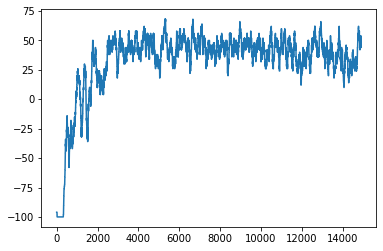

In [ ]:
rewards2 = []
for i in range(0, len(rewards)):
    rewards2.append(sum(rewards[i:i+100]))
    
plt.plot(rewards2[:-100])
plt.show()

##Evaluate the big maze

In [4]:
maze = maze_big
loc = np.array([0, 0]) # y, x

UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
SLIP_PERCENT = 0.4 # Slipping from S

In [5]:
def env_reset():
    global loc
    # Find location of start
    loc = np.dstack(np.nonzero(maze == H)).squeeze()
    return (0, 0., {'maze':np.copy(maze), 'loc':np.copy(loc)})

In [6]:
def env_print():
    ''' Print the environment '''
    global loc, maze
    print('')
    # chars = ['H', '~', '.', 'O', 'G'] 
    chars = ['H', 'S', 'D', 'P', 'G']
    for i, row in enumerate(maze):
        for j, num in enumerate(row):
            if i == loc[0] and j == loc[1]:
                char = 'X'
            else:
                char = chars[int(num)]
            print(char, end=' ')
        print('')

In [7]:
def env_step(action):
    global loc
    
    
    # UP, DOWN, RIGHT, LEFT
#    moves = [(-1, 0), (1, 0), (0, 1), (0, -1)]
    moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    move = np.array(moves[action])

    # Check if slippery
    if maze[tuple(loc)] == S:
        if random.random() < SLIP_PERCENT:
            move = np.array(random.choice(moves))

    loc2 = loc + move

    reward = 0.
    done = 0
    
    
    # Bounds check
    if loc2[0] >= 0 and loc2[1] >= 0 and loc2[0] < len(maze) and loc2[1] < len(maze[0]):
        loc = loc2 # Update loc

        if maze[tuple(loc)] == G:
            reward = 1.
            done = 1
        elif maze[tuple(loc)] == P:
            reward = -1.
            done = 1
        

    return (done, reward, {'maze':np.copy(maze), 'loc':np.copy(loc)})

In [9]:
class Memory_big(object):
    def __init__(self, size=2000):
        self.memory = []
        self.max_size = size
        self.index = 0

    def store(self, x):
        if len(self.memory) < self.max_size:
            self.memory.append(x)
        else:
            self.memory[self.index] = x
            self.index = (self.index + 1) % self.max_size

    def sample(self, num):
        if len(self.memory) < num:
            return self.memory
        else:
            return random.sample(self.memory, num)

In [16]:
# Neural Network with replay memory ----

epochs = 10000
epsilon = 0.2
gamma = 0.9
lr = 0.001
batch_size = 4
rewards = []

(done, reward, state) = env_reset()
state = torch.from_numpy(state['loc']).float()
loss_func = nn.MSELoss()

#TODO initialize your model here
q = Net()
target_q = Net()

optimizer = optim.Adam(lr=lr, params=q.parameters())

memory = Memory_big()

total_iter = 0

replace_iter = 500

def train():
    #TODO sample data with batch_size from memory

    memory_data = memory.sample(batch_size)
    state = []
    state2 = []
    action = []
    reward = []
    done2 = []
    for i in range(batch_size):
      state.append(memory_data[i][0].data.numpy())
      state2.append(memory_data[i][1].data.numpy())
      action.append(int(memory_data[i][2].data.numpy()))
      reward.append(int(memory_data[i][3].data.numpy()))
      done2.append(int(memory_data[i][4].data.numpy()))

    state = torch.FloatTensor(state)
    state2 = torch.FloatTensor(state2)
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    done2 = torch.FloatTensor(done2)
  
    q_values = q(state).gather(1,action.view(-1,1)).squeeze(1)
    q_next = target_q(state2).detach()
    q_target = reward + gamma * torch.max(q_next,1)[0]
    #TODO calculate loss
    loss = loss_func(q_values,q_target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

for epoch in range(epochs):
    iter = 0
    ep_reward = 0.
    while not done:
        if epoch % replace_iter == 0:
          target_q.load_state_dict(q.state_dict())
        # Take a step
        if iter > 200:
            print(epoch,"stuck")
            break
        if random.random() < epsilon:
            action = random.choice([UP, DOWN, LEFT, RIGHT])
            action = torch.Tensor([action])[0].to(dtype=torch.long)
        else:
            #TODO get action according to prediction of model for this state
            with torch.no_grad():
              action = torch.max(q(state),0)[1]

        (done2, reward, state2) = env_step(action)
        state2 = torch.from_numpy(state2['loc']).float()
        
        ep_reward += reward

        # Store data into memory
        memory.store((state, state2, action,
            torch.Tensor([reward])[0], torch.Tensor([done2])[0]))

        # Now learn
        if total_iter > batch_size:
            train()

        state = state2
        done = done2
        iter += 1
        total_iter += 1

    (done2, reward, state) = env_reset()
    done = done2
    rewards.append(ep_reward)
    state = torch.from_numpy(state['loc']).float()

    #epsilon -= 0.00002

729 stuck
1058 stuck
1176 stuck
1356 stuck
1396 stuck
1397 stuck
1425 stuck
1439 stuck
1477 stuck
1490 stuck
1492 stuck


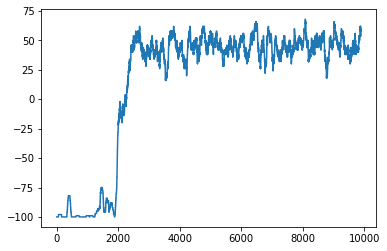

In [17]:
rewards2 = []
for i in range(0, len(rewards)):
    rewards2.append(sum(rewards[i:i+100]))
    
plt.plot(rewards2[:-100])
plt.show()